In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

### Load the dataset ###

In [2]:
! git clone https://github.com/zalandoresearch/fashion-mnist.git

fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


In [3]:
!ls fashion-mnist/data/fashion

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


If you skip the above steps, Tensorflow will download the MNIST dataset, by default.

In [4]:
data = input_data.read_data_sets('fashion-mnist/data/fashion', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
train_images=data.train.images
train_labels=data.train.labels
test_images=data.test.images
test_labels=data.test.labels

In [6]:
print("Shape of training data: ", train_images.shape)
print("Shape of training labels: ", train_labels.shape)
print("Shape of testing data: ", test_images.shape)
print("Shape of testing labels: ", test_labels.shape)

Shape of training data:  (55000, 784)
Shape of training labels:  (55000, 10)
Shape of testing data:  (10000, 784)
Shape of testing labels:  (10000, 10)


### Visualize the dataset ###

In [0]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Text(0.5, 1.0, 'Label: Sandal')

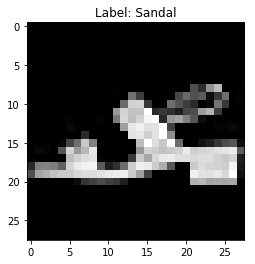

In [8]:
i=112

plt.figure()

# display images from the dataset
lbl = np.argmax(train_labels[i])
plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
plt.title("Label: "+ str(label_dict[lbl]))

### Examine the dataset ###

Basic check - There are no NANs in the input data

In [9]:
np.isnan(train_images).any()

False

### Data preprocessing ###
We need to reshape the images to feed it as an input to the network. The images should be reshaped to have dimension 28 * 28 * 1. 

Note - No need to normalize the images as the images are already in the range 0 to 1. 

In [10]:
print(np.min(train_images[0]), "\t", np.max(train_images[0]))

0.0 	 1.0


In [0]:
# reshape the images to feed it to the network
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28,1)

In [12]:
train_images[0].shape

(28, 28, 1)

### Defining Hyperparameters ###

In [0]:
steps_num = 100 # training epochs - number of times you want to repeat the training on the same dataset.
learning_rate = 0.001 # learning rate/step size - controls how much we are adjusting the weights of the network w.r.t. to the loss gradients.
batch_size = 128 # chooses the images in batches 

It is recommended to use a batch size in the power of 2, since the number of physical processor is often a power of 2.
Make sure that your machine has sufficient RAM to handle the specific batch size.

### Network parameters ###

In [0]:
image_size= 28 # Fashion MNIST data input
labels_size = 10 # Fashion MNIST classes

### Setup the architecture ###

In [0]:
# defining placeholders
training_data = tf.placeholder(tf.float32, [None, image_size, image_size, 1]) # input placeholder
labels = tf.placeholder(tf.float32, [None, labels_size]) # output data

The first dimension is None. It tells the placeholder that it will receive this dimension when you feed in the data to it. 

### Wrapper functions ###

Checkout:

tf.nn.conv2d https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

tf.nn.max_pool https://www.tensorflow.org/api_docs/python/tf/nn/max_pool

In [0]:
# convolution layer + Relu
def conv2d(x, W, b, s):
  # stride in the first and last dimension is always 1. First dimension is the image number and the last dimension is for the input channel.
  # padding 'SAME' - to keep the dimension same.
  y = tf.nn.conv2d(x, W, strides=[1, s, s, 1], padding='SAME') 
  y = tf.nn.bias_add(y, b)
  y = tf.nn.relu(y)
  return y

# Max pooling layer
def maxpool2d(X, k):
  y = tf.nn.max_pool(X, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
  return y

### Weight and Bias Parameters ###

#### For conv layers: ####

A **weight variable** will be of the form: **(f, f, c, out_c)** - You apply out_c number of filters of size f X f across c channels.

The first and second parameter are the filter size, third parameter is the input number of channels, fourth parameter is the output number of channel of the layer.


#### For fully connected layers: ####

Since we will flatten the image before feeding into the fully connected layers. The weights of the FC layers are of the form - **(input_dim, output_dim)**


A **bias variable** shape is equivalent to the number of output channels of that layer.


In [0]:
weights = {
    'wc1' : tf.get_variable('W0', shape=(3, 3, 1, 32), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2' : tf.get_variable('W1', shape=(3, 3, 32, 64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape=(3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape=(4*4*128, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd2' : tf.get_variable('W4', shape=(128, 10), initializer=tf.contrib.layers.xavier_initializer())
}

In [0]:
biases = {
    'bc1' : tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2' : tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3' : tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1' : tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd2' : tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

In [0]:
def model(X, weights, biases):
  # convolution block 1
  conv1 = conv2d(X, weights['wc1'], biases['bc1'], 1)
  conv1 = maxpool2d(conv1, k=2) # returns an output of shape 14 X 14
  conv1 = tf.nn.dropout(conv1, keep_prob=0.3)
  
  # convolution block 2
  conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], 1)
  conv2 = maxpool2d(conv2, k=2) # returns an output of shape 7 X 7
  conv2 = tf.nn.dropout(conv2, keep_prob=0.3)
  
  # convolution block 3
  conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], 1)
  conv3 = maxpool2d(conv3, k=2) # returns an output of shape 4 X 4
  conv3 = tf.nn.dropout(conv3, keep_prob=0.4)
  
  # Fully connected layers
  fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
  fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
  fc1 = tf.nn.leaky_relu(fc1)
  fc1 = tf.nn.dropout(fc1, keep_prob=0.3)
  
  # Final layer
  output = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
  return output

Read more about the cross entropy loss function.

https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits

To learn more about the Adam optimizer, look here.

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [20]:
predict = model(training_data, weights, biases)

# tf.reduce_mean calculates the mean over all the batches to get the single loss value.
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=labels))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Evaluating the model predictions ###

In [0]:
prediction = tf.argmax(predict, 1)
gt = tf.argmax(labels, 1)

correct_pred = tf.equal(prediction, gt)

# calculate the accuracy across the images and average them out.
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Training the model ###

In [22]:
# initialize the global variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  
  train_loss, test_loss, train_acc, test_acc = [], [], [], []
  
  for ep in range(steps_num):
    train_loss_ep, train_acc_ep = [], []
    for itr in range(len(train_images)//batch_size):
      batch_x = train_images[itr*batch_size:min((itr+1)*batch_size, len(train_images))]
      batch_y = train_labels[itr*batch_size:min((itr+1)*batch_size, len(train_images))]
      
      # run the optimizer, loss and accuracy
      opt = sess.run(optimizer, feed_dict={training_data: batch_x, labels: batch_y})
      
      _, loss_val, acc_val = sess.run([optimizer, loss, accuracy], feed_dict={training_data: batch_x, labels: batch_y})
      
#       if np.isnan(loss_val):
#         print("Iteration: ", itr)
#         print(batch_x.shape)
#         print(batch_y.shape)
        
      assert(not np.isnan(loss_val))
      
      train_loss_ep.append(loss_val)
      train_acc_ep.append(acc_val)
      
    # find the training loss and accuracy per epoch
    train_loss_per_epoch = np.mean(np.array(train_loss_ep))
    train_loss.append(train_loss_per_epoch)
    train_acc_per_epoch = np.mean(np.array(train_acc_ep))
    train_acc.append(train_acc_per_epoch)
    
    print("\nEpoch: {:0d} \t Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(ep, train_loss_per_epoch, train_acc_per_epoch))
     
    # find testing loss and accuracy 
    test_loss_ep, test_acc_ep = sess.run([loss, accuracy], feed_dict={training_data: test_images, labels: test_labels})
    
    print("\nTesting Loss: {:.3f}, Testing Accuracy: {:.3f}".format(test_loss_ep, test_acc_ep))
    test_acc.append(test_acc_ep)
    test_loss.append(test_loss_ep)


Epoch: 0 	 Training Loss: 1.064, Training Accuracy: 0.604

Testing Loss: 0.719, Testing Accuracy: 0.732

Epoch: 1 	 Training Loss: 0.642, Training Accuracy: 0.762

Testing Loss: 0.610, Testing Accuracy: 0.774

Epoch: 2 	 Training Loss: 0.573, Training Accuracy: 0.787

Testing Loss: 0.577, Testing Accuracy: 0.789

Epoch: 3 	 Training Loss: 0.533, Training Accuracy: 0.804

Testing Loss: 0.548, Testing Accuracy: 0.795

Epoch: 4 	 Training Loss: 0.515, Training Accuracy: 0.811

Testing Loss: 0.521, Testing Accuracy: 0.807

Epoch: 5 	 Training Loss: 0.492, Training Accuracy: 0.817

Testing Loss: 0.508, Testing Accuracy: 0.814

Epoch: 6 	 Training Loss: 0.479, Training Accuracy: 0.823

Testing Loss: 0.517, Testing Accuracy: 0.810

Epoch: 7 	 Training Loss: 0.472, Training Accuracy: 0.826

Testing Loss: 0.485, Testing Accuracy: 0.823

Epoch: 8 	 Training Loss: 0.457, Training Accuracy: 0.833

Testing Loss: 0.490, Testing Accuracy: 0.825

Epoch: 9 	 Training Loss: 0.456, Training Accuracy: 0.

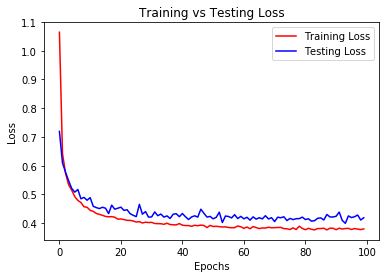

In [23]:
# Visualize the loss.
plt.plot(range(len(train_loss)), train_loss, 'r', label="Training Loss")
plt.plot(range(len(test_loss)), test_loss, 'b', label="Testing Loss")
plt.title("Training vs Testing Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

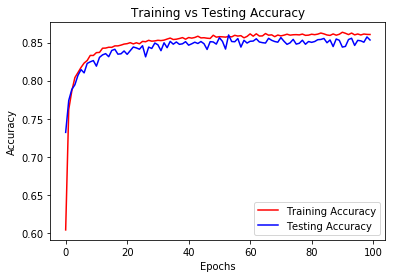

In [24]:
# Visualize the accuracy.
plt.plot(range(len(train_acc)), train_acc, 'r', label="Training Accuracy")
plt.plot(range(len(test_acc)), test_acc, 'b', label="Testing Accuracy")
plt.title("Training vs Testing Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()